<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/08-ensembles/Ensembles_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [28]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

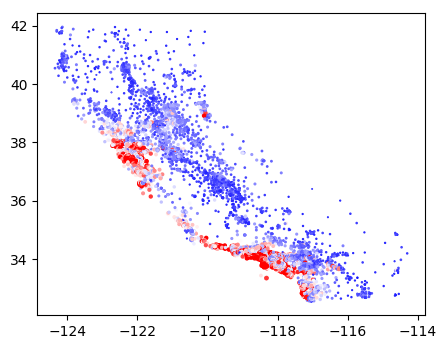

In [29]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [30]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


 - Build a kNN regressor on the `Longitude` and `Latitude` features (**0.5 point**)
 - Build a random forest regressor on the rest of the features (**0.5 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models. (**4 points**)
 - Compare the test MSE losses of the 3 models above, leave a comment (**1 point**)
 

Make sure to have a look at the documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [31]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


## 1.Build a kNN regressor on the Longitude and Latitude features 

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.iloc[:,[6,7]])

StandardScaler()

In [33]:
from sklearn.model_selection import GridSearchCV
parameters={
    'weights':['uniform', 'distance'],
    'leaf_size': [10,20,30,40],
    'n_jobs':[1,2,3]
}
kN_model=KNeighborsRegressor()
clf_KN=GridSearchCV(kN_model,parameters,cv=10)
X_train_lat_long=scaler.transform(X_train.iloc[:,[6,7]])
clf_KN.fit(X_train_lat_long,y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'leaf_size': [10, 20, 30, 40], 'n_jobs': [1, 2, 3],
                         'weights': ['uniform', 'distance']})

In [34]:
print(clf_KN.best_params_)
print(clf_KN.best_estimator_)
print(clf_KN.best_score_)

{'leaf_size': 30, 'n_jobs': 1, 'weights': 'uniform'}
KNeighborsRegressor(n_jobs=1)
0.786621040255658


## 2.Build a random forest regressor on the rest of the features 

In [35]:
scaler = StandardScaler()
scaler.fit(X_train.iloc[:,[0,1,2,3,4,5]])
Random_model=RandomForestRegressor()
parameters={
    'max_depth':[3,5,6],
    'criterion':['squared_error', 'poisson']
}
clf_Random=GridSearchCV(Random_model,parameters,cv=10)
X_train_random=scaler.transform(X_train.iloc[:,[0,1,2,3,4,5]])
clf_Random.fit(X_train_random,y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'poisson'],
                         'max_depth': [3, 5, 6]})

In [36]:
print(clf_Random.best_params_)
print(clf_Random.best_estimator_)
print(clf_Random.best_score_)
predict_random=clf_Random.predict(X_test.iloc[:,[0,1,2,3,4,5]].values)

{'criterion': 'squared_error', 'max_depth': 6}
RandomForestRegressor(max_depth=6)
0.6705724739430605


## 3.Build a stacking regressor (sklearn.ensemble.StackingRegressor) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models.

In [37]:
estimators={
    ('KNeighborsRegressor',kN_model),
    ('RandomForestRegressor',Random_model),
}
stack_model=StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5

)
stack_model.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators={('KNeighborsRegressor', KNeighborsRegressor()),
                              ('RandomForestRegressor',
                               RandomForestRegressor())},
                  final_estimator=LinearRegression())

In [38]:
pred = stack_model.predict(X_test)
print(pred)
score = r2_score(y_test, pred)
print(score)

[4.58678912 2.91745056 4.28049529 ... 2.65627958 1.52238393 0.88379055]
0.7986131765982065


## 4.Compare the test MSE losses of the 3 models above, leave a comment  

In [39]:
print('The MSE of kNN is: ', mean_squared_error(y_test,predictions_kN))
print('The MSE of random forest regressor is: ',mean_squared_error(y_test,predict_random))
print('The MSE of stacking is: ',mean_squared_error(y_test,pred))

The MSE of kNN is:  3.0760738763839726
The MSE of random forest regressor is:  6.1766363778683395
The MSE of stacking is:  0.26960730111696146


## Conclusion:
###  As the ensemble stacking model is using the KNN and Random Forest's predictions as input for a Linear Regression model, so the accuracy is relatively higher than both KNN and Random Forest. 